In [1]:
import os
import fitz  # PyMuPDF
import ollama
import re
from mistralai import Mistral
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display, Image as IPImage

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

In [3]:
def convert_page_to_image64(page, remove_header=False, remove_footer=False, header_height=390, footer_height=140):
    pix = page.get_pixmap(dpi=300)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Define the crop box (left, upper, right, lower)
    left, upper, right, lower = 0, 0, img.width, img.height
    if remove_header:
        upper = header_height
    if remove_footer:
        lower -= footer_height

    cropped_img = img.crop((left, upper, right, lower))
    
    # buffered = BytesIO()
    # cropped_img.save(buffered, format="png")
    # return base64.b64encode(buffered.getvalue())

    buffered = BytesIO()
    cropped_img.save(buffered, format="PNG")
    img_bytes = buffered.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")
    return img_base64



In [47]:
def pdf_to_markdown(pdf_filepath, markdown_filepath, prompt, model, api=False):

    doc = fitz.open(pdf_filepath)
    markdown_output = []

    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        img_base64 = convert_page_to_image64(page, remove_header=True, remove_footer=True, header_height=250, footer_height=250)

        last_page_markdown = markdown_output[-1] if markdown_output else ""

        final_prompt = f"{prompt}\n\nLast processed page:\n{last_page_markdown}\n\nThis page:\n" if markdown_output else prompt

        try:
            if api:
        
                messages = [
                    {
                    "role": "user",
                    "content": [
                        {
                        "type": "text",
                        "text": final_prompt,
                        },
                        {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{img_base64}"
                        }
                        }
                    ]
                    }
                ]

                client = Mistral(api_key=MISTRAL_API_KEY)
                response = client.chat.complete(model=model, messages=messages, temperature=0.0)
                markdown_output.append(response.choices[0].message.content)
            else:
                messages = [
                                {
                                    'role': 'user',
                                    'content': final_prompt,
                                    'images': [img_base64]
                                }
                            ]
                response = ollama.chat(model=model, messages=messages)
                markdown_output.append(response['message']['content'])
        except Exception as e:
            print(f"Error processing page {page_num + 1}: {e}")
            markdown_output.append(f"<!-- Error on page {page_num + 1} -->")

    markdown_saved_filepath = markdown_filepath.replace('.md', '___' + model + '___.md')

    with open(markdown_saved_filepath, 'w', encoding='utf-8') as f:
        # Parse the markdown content to remove ```markdown and ```
        cleaned_output = []
        for content in markdown_output:
            match = re.search(r"```markdown(.*?)```", content, re.DOTALL)
            if match:
                cleaned_output.append(match.group(1).strip())
            else:
                cleaned_output.append(content.strip())
        f.write('\n\n'.join(cleaned_output))

    print(f"Markdown saved to {markdown_saved_filepath}")



In [48]:
french_prompt = """
Vous êtes un modèle linguistique avancé. Votre tâche consiste à lire une page PDF qui a été rendue sous forme d'image. L'objectif est de transformer le contenu de cette image en format Markdown. Étant donné que Markdown est uniquement textuel, vous devrez également décrire toutes les images trouvées dans la page PDF sous forme de texte. Le PDF contient des informations géographiques, donc assurez-vous que les détails géographiques sont capturés et formatés avec précision.

Instructions spécifiques :

    Extraire le texte : Identifiez et extrayez tout le contenu textuel de l'image, en prêtant une attention particulière aux termes géographiques et aux détails spécifiques à la géographie.
    Convertir en Markdown : Formatez le texte extrait en utilisant la syntaxe Markdown, en veillant à ce que les titres, sous-titres, listes et autres formats pertinents soient correctement utilisés.
    Décrire et interpréter les images : Pour chaque image trouvée dans le PDF, rédigez un texte descriptif qui transmet le contenu et le contexte de l'image. Si l'image est une carte, essayez d'interpréter ce que la carte veut dire et le message qu'elle souhaite faire passer, en vous concentrant sur les éléments clés tels que les légendes, les symboles et les zones géographiques représentées.

Exemple :

Si la page PDF contient un titre, un paragraphe et une image décrivant une carte des zones climatiques, votre sortie devrait ressembler à ceci :

```markdown
# Carte des Zones Climatiques

Ceci est un paragraphe extrait de la page PDF. Il contient des informations sur les différentes zones climatiques de la région étudiée.

## Zones Climatiques

- Zone tropicale
- Zone tempérée
- Zone polaire

![Description de la carte : Cette image illustre les différentes zones climatiques de la région. Les zones sont colorées pour indiquer les variations de température et de précipitations. La légende montre que la zone tropicale est caractérisée par des températures élevées et des précipitations abondantes, tandis que la zone polaire est marquée par des températures très basses et des précipitations faibles. Cette carte met en évidence l'impact du climat sur la biodiversité et l'habitat humain dans chaque zone.]
```

"""

In [34]:
from pathlib import Path

def get_all_files_with_extension(root_directory, target_extension):
    files = []
    target_extension = target_extension.lower()
    
    root_path = Path(root_directory)
    if root_path.exists() and root_path.is_dir():
        for file_path in root_path.rglob('*'):
            if file_path.suffix.lower() == target_extension:
                files.append(str(file_path))
    
    return files

pdfs = get_all_files_with_extension('pdf', '.pdf')

In [35]:
model = 'mistral-small-latest'
# model = 'gemma3:4b'

In [49]:
for pdf_filepath in pdfs:
    markdown_filepath = pdf_filepath.replace('pdf', 'md')
    pdf_to_markdown(pdf_filepath, markdown_filepath, french_prompt, model, api=True)

Markdown saved to md\D31733___mistral-small-latest___.md


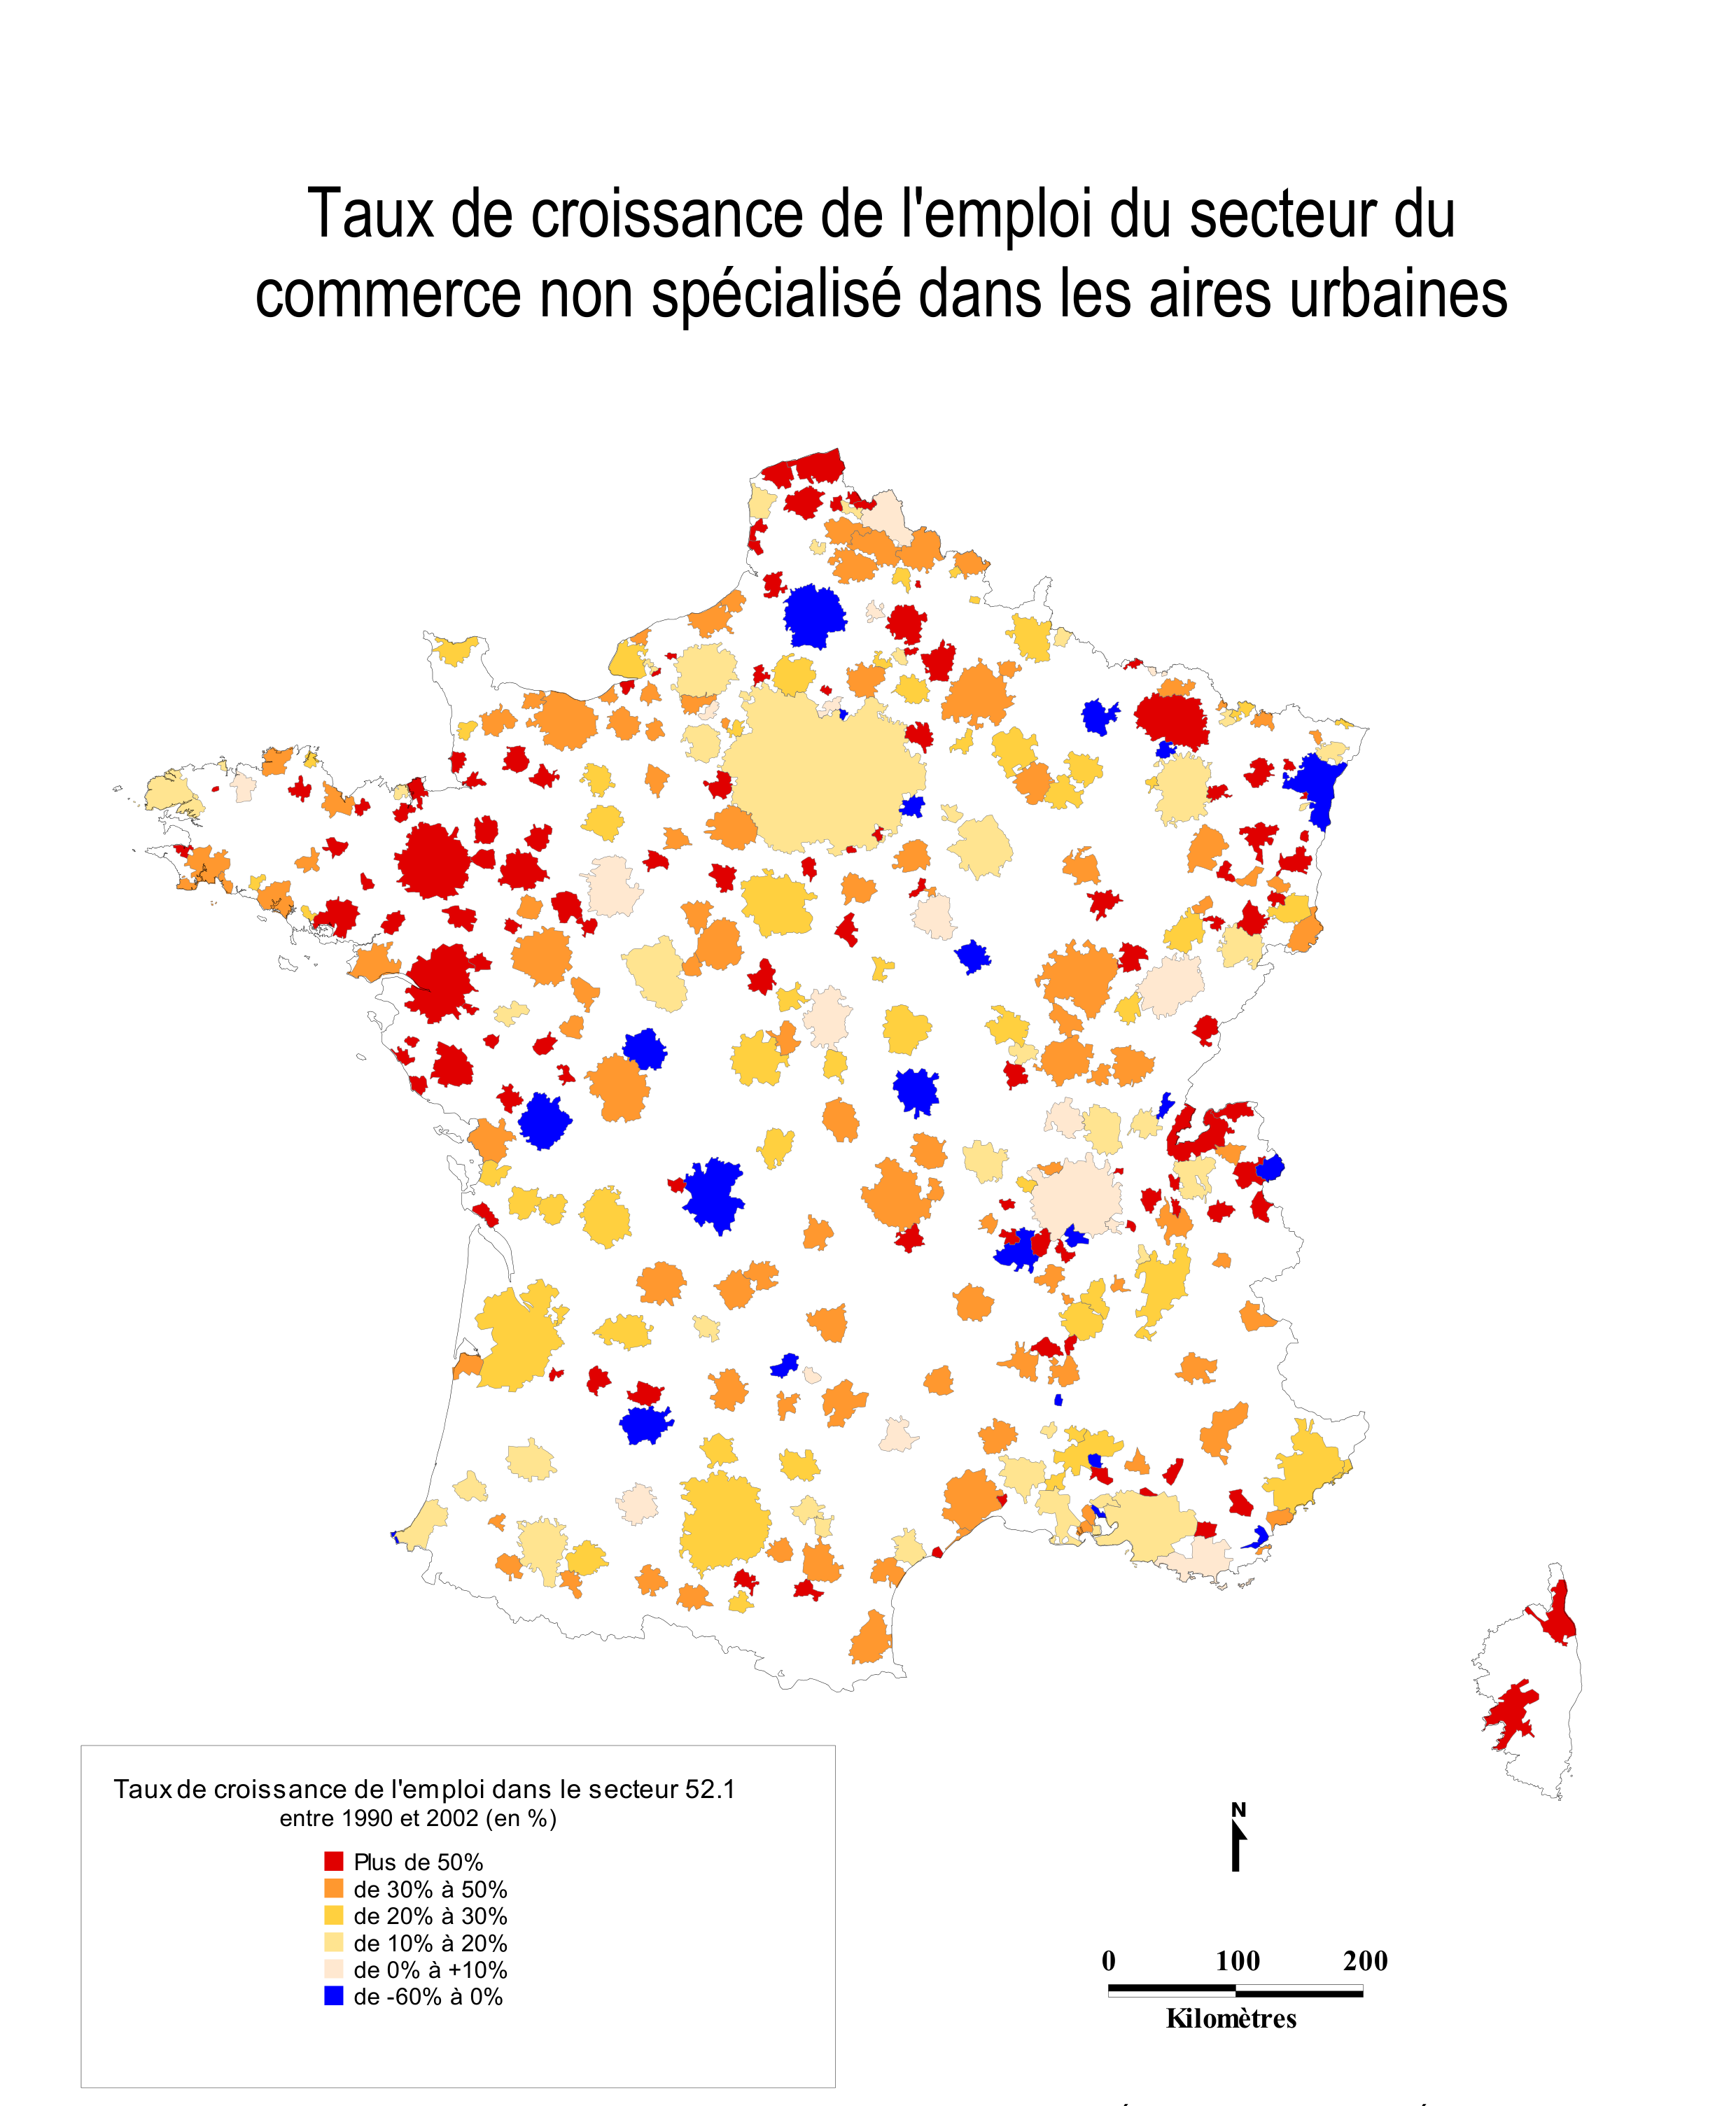

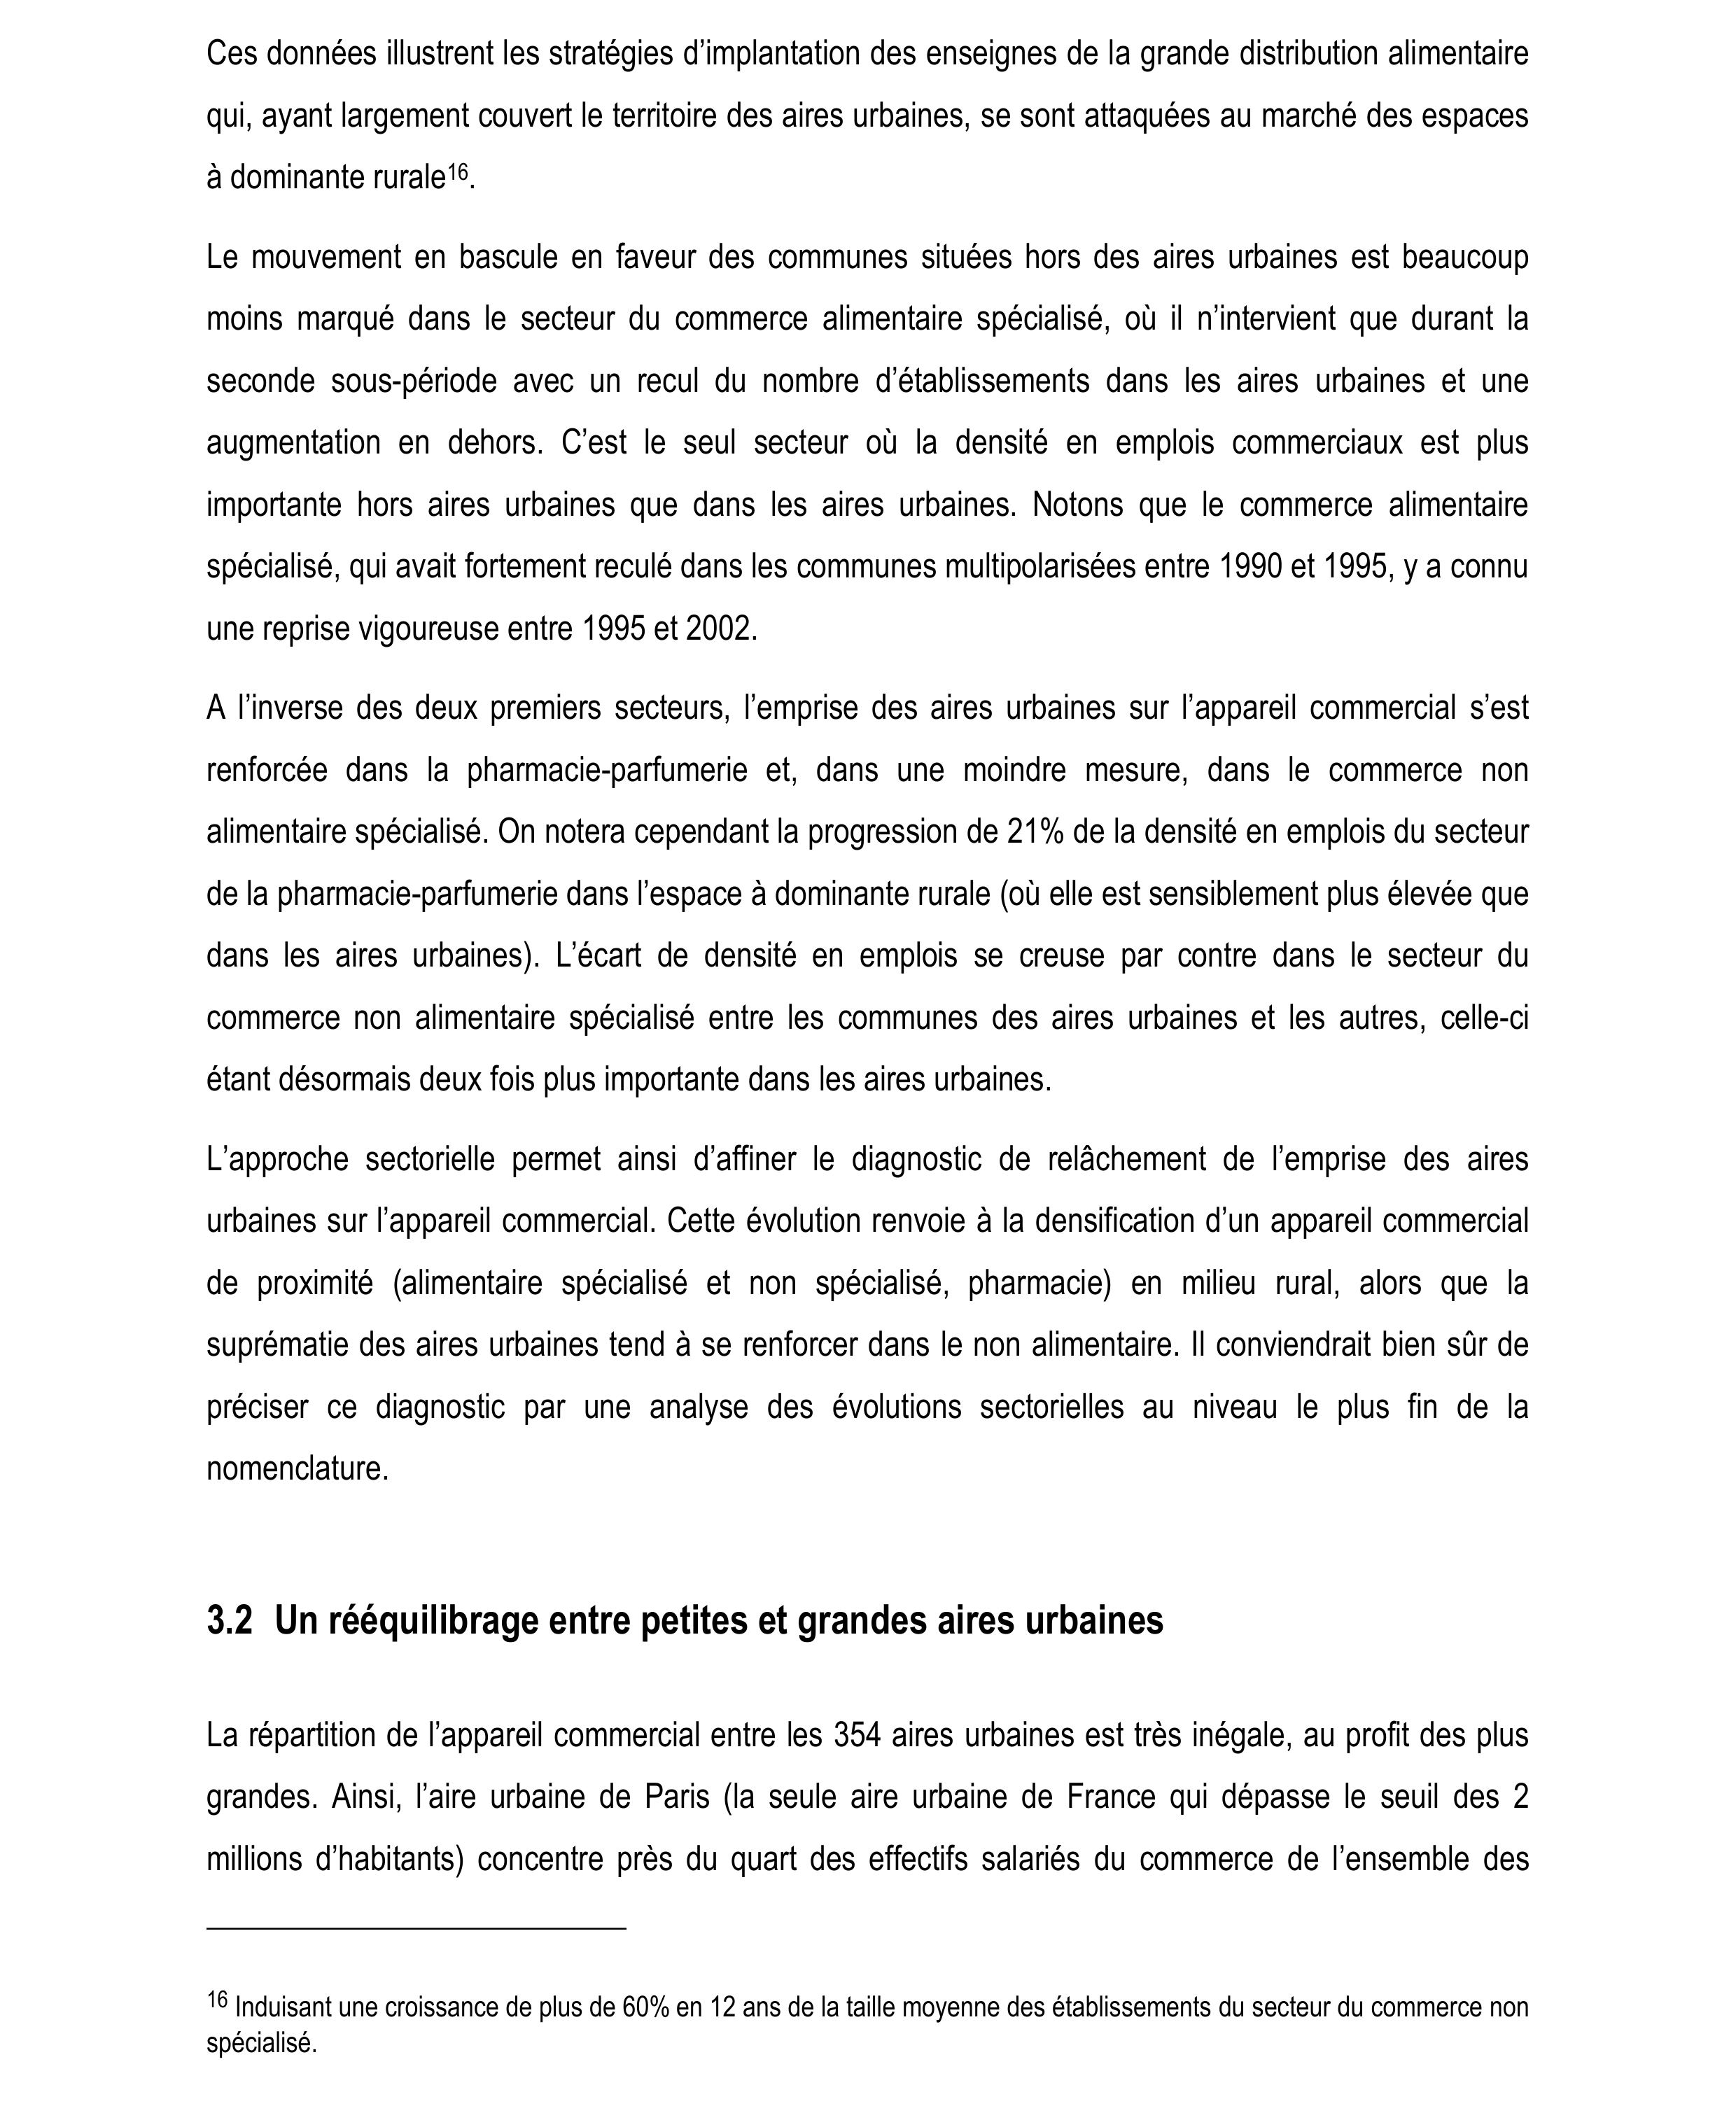

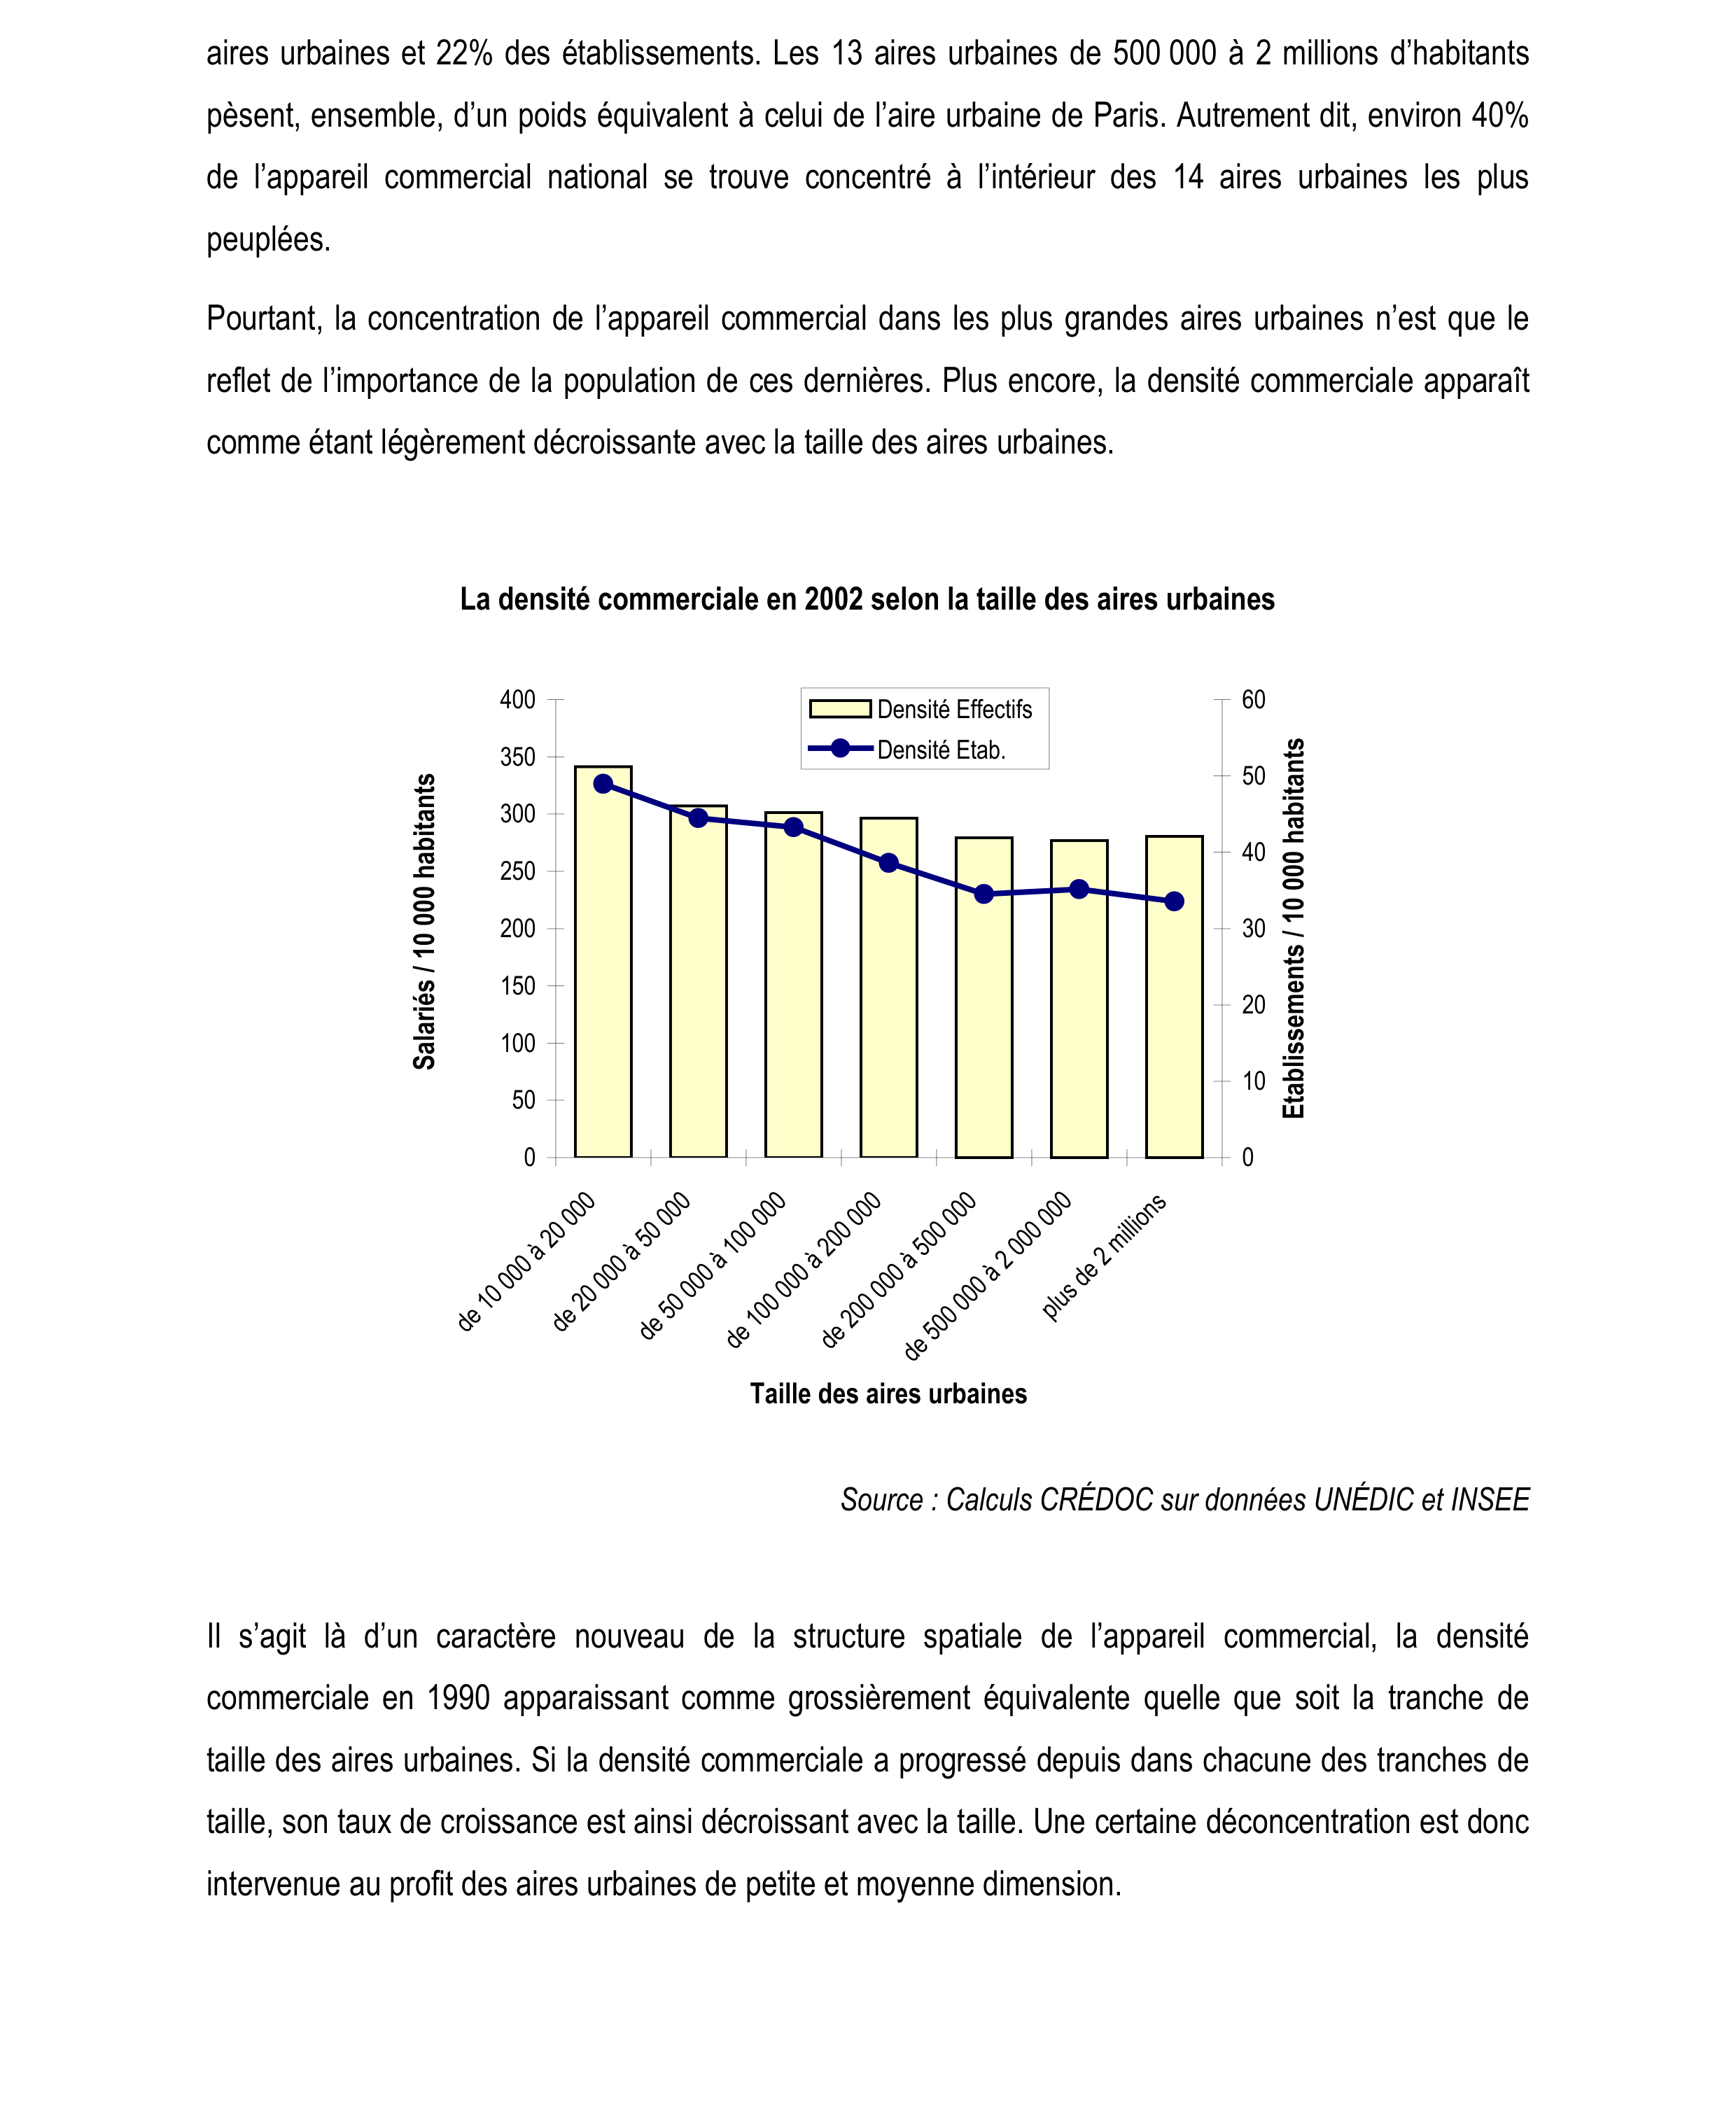

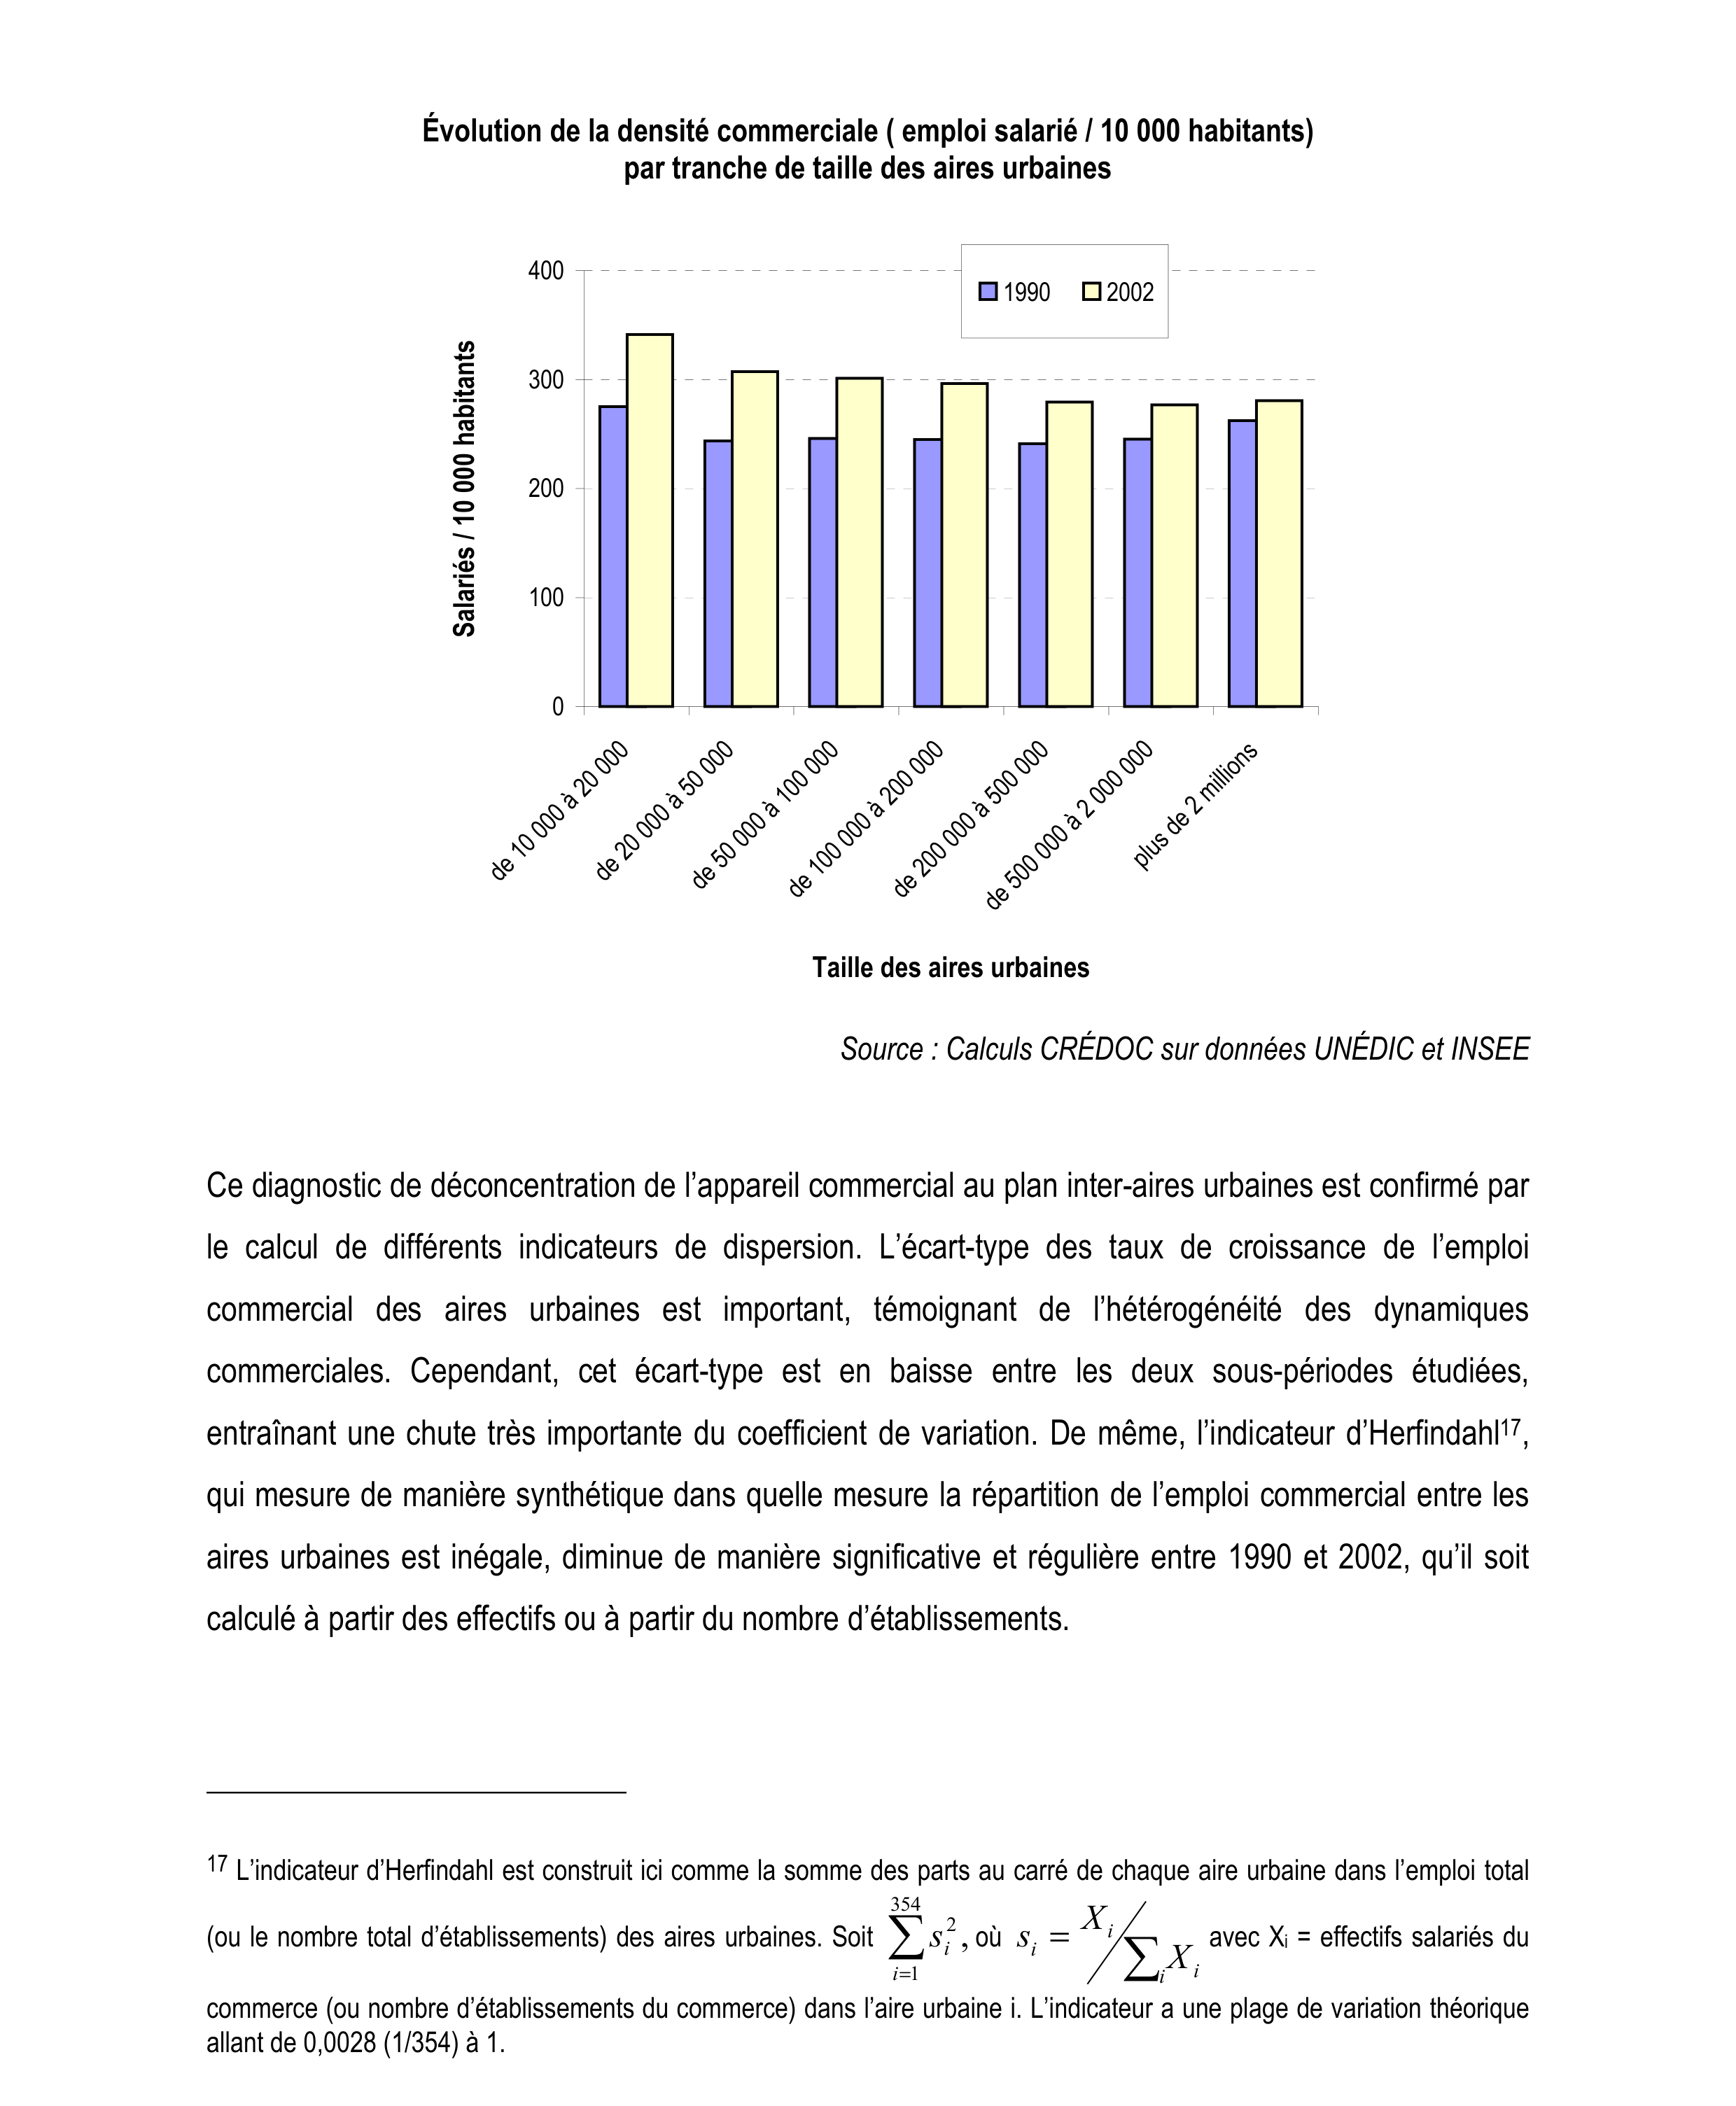

In [44]:
pdf_path = pdfs[0]
doc = fitz.open(pdf_path)

for page_num in range(20, min(len(doc), 24)):
    page = doc.load_page(page_num)
    img_base64 = convert_page_to_image64(page, remove_header=True, remove_footer=True, header_height=250, footer_height=250)
    display(IPImage(data=base64.b64decode(img_base64)))
    # break # Comment this line to display all pages